# Capstone Project #1: A Guide to Selecting Your Next Craft Beer
## Data Storytelling & Initial Analysis

Date: May 16, 2017

## Analyses of Interest:
1.	How do my individual beer ratings compare to the average user’s ratings?
2.	Does there appear to be a difference in ratings based on style of beer?
3.	Does there appear to be a difference in ratings based on country of production?
4.	Do my individual ratings appear to change over time? 

In [1]:
import pandas as pd #for building dataframes from CSV files
import glob, os #for reading file names
import seaborn as sns #for fancy charts
import numpy as np #for np.nan
from scipy import stats #for statistical analysis
from scipy.stats import norm #for statistical analysis
from datetime import datetime #for time-series plots
import statsmodels #for integration with pandas and analysis
import matplotlib.pyplot as plt 
%matplotlib inline  

In [2]:
#Initialize dataframes given API data
my_beer_df = pd.read_csv('../data/my-final-beer-data.csv')

In [3]:
my_beer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 35 columns):
beer.auth_rating                  181 non-null float64
beer.beer_abv                     181 non-null float64
beer.beer_description             181 non-null object
beer.beer_ibu                     181 non-null int64
beer.beer_label                   181 non-null object
beer.beer_name                    181 non-null object
beer.beer_slug                    181 non-null object
beer.beer_style                   181 non-null object
beer.bid                          181 non-null int64
beer.created_at                   181 non-null object
beer.rating_count                 181 non-null int64
beer.rating_score                 181 non-null float64
beer.wish_list                    181 non-null bool
brewery.brewery_active            181 non-null int64
brewery.brewery_id                181 non-null int64
brewery.brewery_label             181 non-null object
brewery.brewery_name              1

#Keep in mind that a few of the non-null objects were filled with 'NO_INFORMATION' so we may need to filter these values later

In [4]:
#Let's check the statistics around the quantitative factors
my_beer_df.describe()

,beer.auth_rating,beer.beer_abv,beer.beer_ibu,beer.bid,beer.rating_count,beer.rating_score,brewery.brewery_active,brewery.brewery_id,brewery.location.lat,brewery.location.lng,count,first_checkin_id,rating_score,recent_checkin_id,recent_created_at_timezone
count,181.000000,181.000000,181.000000,1.810000e+02,181.000000,181.000000,181.0,181.000000,181.000000,181.000000,181.000000,1.810000e+02,181.000000,1.810000e+02,181.000000
mean,3.392265,5.870442,27.127072,4.060896e+05,23517.895028,3.438840,1.0,35393.983425,22.990224,-12.951038,1.016575,3.797118e+08,3.392265,3.808877e+08,0.447514
std,0.642906,1.900491,77.978276,5.526310e+05,45528.404033,0.398313,0.0,72053.724608,28.034327,88.612863,0.128025,4.582607e+07,0.642906,4.570316e+07,6.160245
min,1.500000,0.000000,0.000000,1.540000e+02,18.000000,2.319000,1.0,17.000000,-53.155200,-156.437000,1.000000,2.943933e+08,1.500000,2.943933e+08,-8.000000
25%,3.000000,5.000000,0.000000,1.197400e+04,986.000000,3.168000,1.0,1204.000000,4.717360,-87.900200,1.000000,3.364364e+08,3.000000,3.378019e+08,-5.000000
50%,3.500000,5.400000,0.000000,6.970200e+04,4414.000000,3.537000,1.0,4573.000000,35.643200,0.000000,1.000000,3.761521e+08,3.500000,3.764025e+08,2.000000
75%,3.750000,6.370000,40.000000,7.277380e+05,21438.000000,3.729000,1.0,19884.000000,42.314400,19.932100,1.000000,4.255308e+08,3.750000,4.263267e+08,7.000000
max,5.000000,16.900000,1000.000000,1.932539e+06,340554.000000,4.560000,1.0,299073.000000,58.356800,174.780000,2.000000,4.493459e+08,5.000000,4.493459e+08,12.000000


# Question 1: Investigating difference in my ratings vs the average user

## For the purposes of this analysis: 
## Beer.auth_rating = My ratings (per beer)
## Beer.rating_score = the Average User Ratings (per beer)

In [5]:
#This looks to be of the most interest, given I am curious how different my ratings are compared to the avg user
my_beer_df[['beer.auth_rating', 'beer.rating_score']].describe()

,beer.auth_rating,beer.rating_score
count,181.000000,181.000000
mean,3.392265,3.438840
std,0.642906,0.398313
min,1.500000,2.319000
25%,3.000000,3.168000
50%,3.500000,3.537000
75%,3.750000,3.729000
max,5.000000,4.560000


While the means are very similar, there appears to be noticeable differences in standard deviation of the ratings. We will explore this further in the statistical inference analysis. 

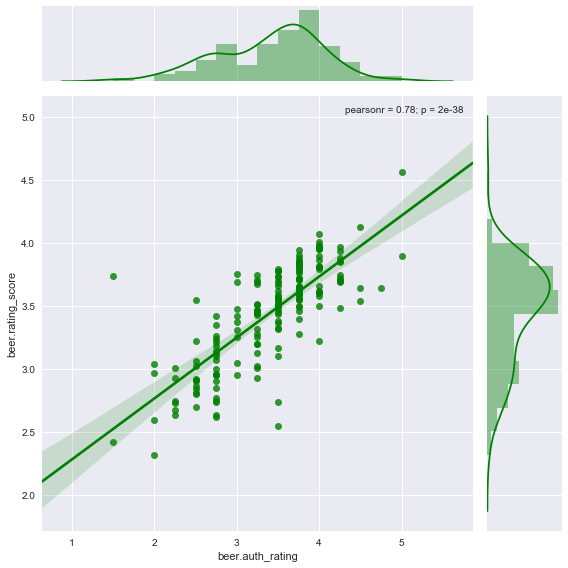

In [6]:
#let's visualize my ratings vs the avg user
sns.jointplot(x="beer.auth_rating", y="beer.rating_score", data=my_beer_df, kind='reg', color='green', size=8);

Visually comparing the two ratings, we see that there appears to be a positive correlation (reiterated by the 0.71 pearsonr coefficient), meaning that as my ratings increase so do the average user’s ratings.


# Question 2: Are there differences by style of beer?

First, let’s take a look at my ratings by beer style to see the mean comparison as well as the disparity of my ratings by style. 

Taking the mean of ratings by style of beer, and then the differences between my ratings and the average user (my rating – average user rating) we can visually look at some of the styles that differ.


In [7]:
#Need to create a new dataframe and column that compares my rating vs the avg user rating
beer_diff = my_beer_df.groupby(['beer.beer_style'], as_index=False)[('beer.auth_rating', 'beer.rating_score')].mean()

In [8]:
#Here is the new column, named 'diff'
beer_diff['diff'] = beer_diff['beer.auth_rating'] - beer_diff['beer.rating_score']

In [9]:
#Let's isolate the top 15 styles for visualization
top_diff = beer_diff.sort_values(by='diff', ascending=False).head(15)

In [10]:
#Märzen causes an ASCII issue with plotting, need to research this further
top_diff = top_diff[top_diff['beer.beer_style'] != 'Märzen']

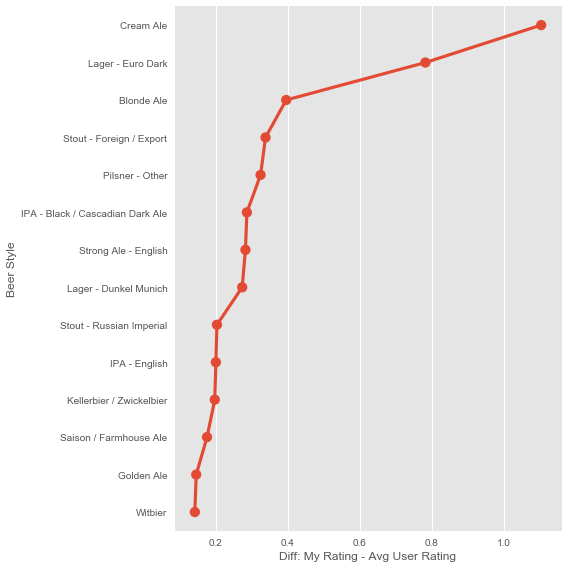

In [28]:
#Factorplot showing the beer styles with ratings that differ the most between myself and the avg user rating
#This factorplot shows the styles that I tend to rate HIGHER than the average user
t = sns.factorplot(x='diff', y='beer.beer_style', data=top_diff, size=8)
t.set_axis_labels('Diff: My Rating - Avg User Rating','Beer Style')

We see that “Ale” beers appear frequently (IPA, Pale Ale, etc.) which I tend to rate higher than the average user. This is consistent with the fact that “Ales” are my favorite style of beer.  


In [12]:
#Let's do a similar analysis for the beers that I like less than the average user
bottom_diff = beer_diff.sort_values(by='diff', ascending=True).head(14)

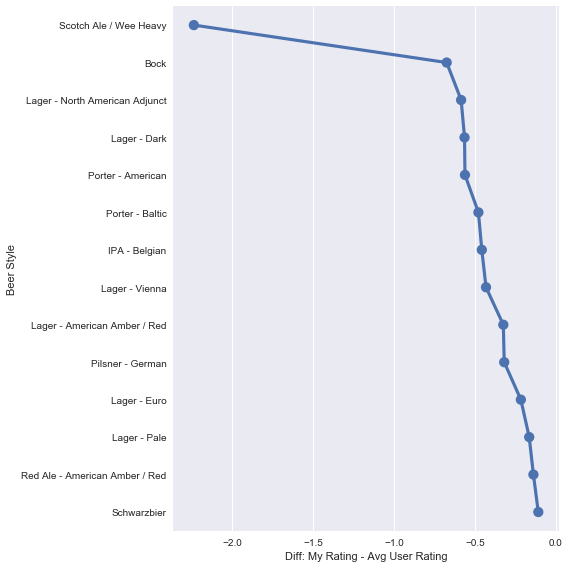

In [13]:
#Factorplot showing the beer styles with ratings that differ the most between myself and the avg user rating
#This factorplot shows the styles that I tend to rate LOWER than the average user
b = sns.factorplot(x='diff', y='beer.beer_style', data=bottom_diff, size=8)
b.set_axis_labels('Diff: My Rating - Avg User Rating','Beer Style')

Although spread across many styles, the chart on the left shows that I tend to rate “lager” beers lower than the average user. Also, I really do not like “Scotch Ale/Wee Heavy”. I would agree with this conclusion. 

In [14]:
#Now, a boxplot showing ALL beer styles
filtered_my_beer_df = my_beer_df[my_beer_df['beer.beer_style'] !='Märzen']

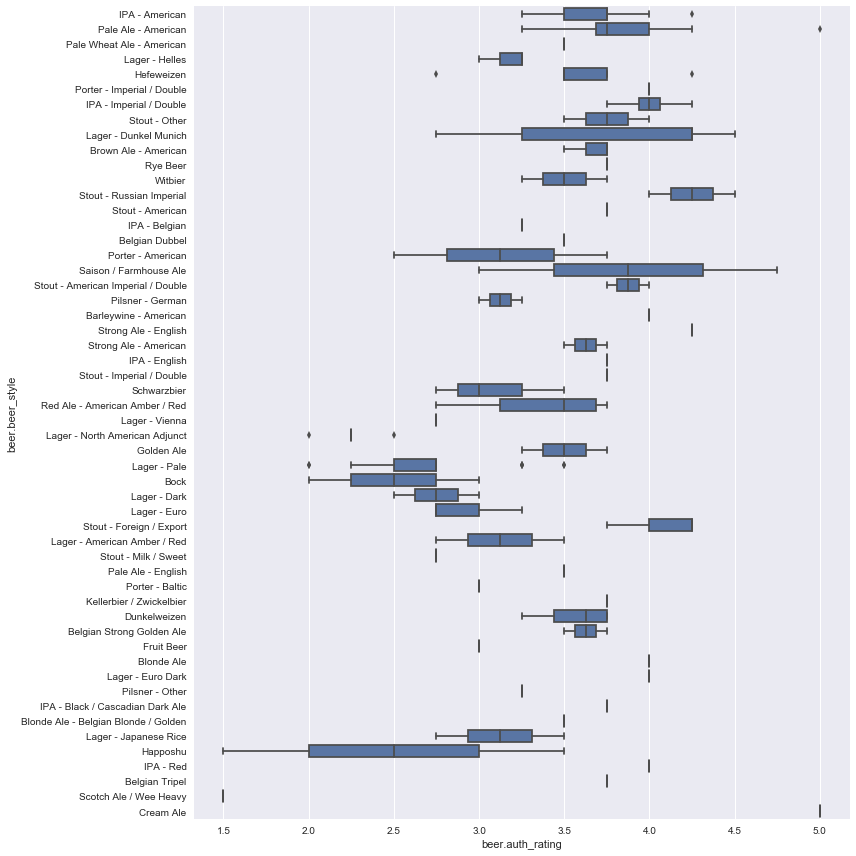

In [15]:
#Massive boxplot by beer style
s = sns.FacetGrid(filtered_my_beer_df, size=12, aspect=1.0)
s.map(sns.boxplot, "beer.auth_rating", "beer.beer_style")

Three major callouts here:
1.	The mean ratings vary quite a bit by style. This is important to note because it means that not all beer is created equal. 
2.	By style, we see pretty wide intervals, even some outliers by style. This means that even by style, not all beer is created equal. 
3.	It appears that I enjoy the “Ale” and “Stout” beer styles the most, but how does this compare to the average user rating? I will explore this next.

# Question 3: Are there differences in ratings due to country of production?


Given that my wife and I have recently returned from traveling the world for 11 months, I want to look if there is a difference in ratings across countries. We can look at boxplot by country of beer production and review the ratings. 


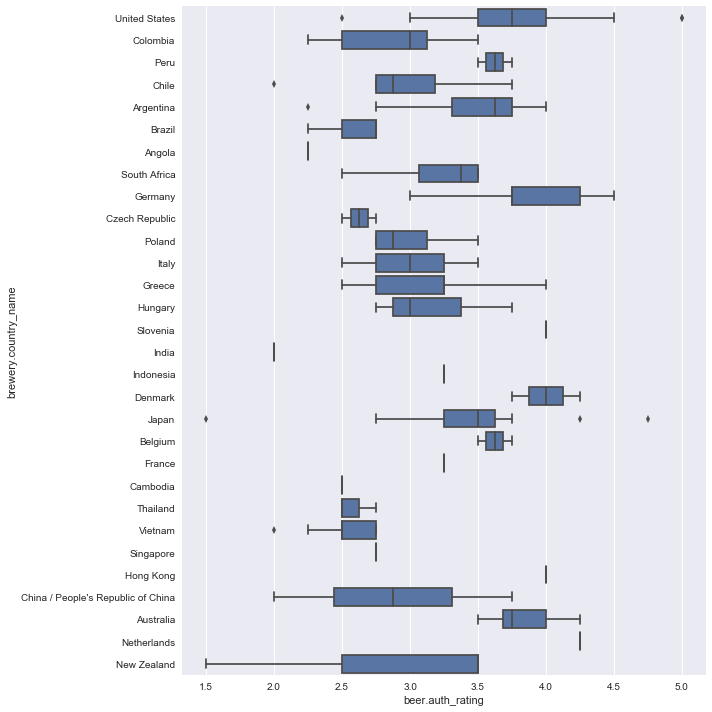

In [16]:
#Boxplot by brewery country of origin
c = sns.FacetGrid(filtered_my_beer_df, size=10, aspect=1.0)
c.map(sns.boxplot, "beer.auth_rating", "brewery.country_name")

Three major callouts here:
1.	It appears that my ratings are highest for beer produced in United States, Germany, Denmark, and Australia. I would agree with United States and Germany, but Denmark and Australia may have to be adjusted based on sample size. 
2.	Beer across the southeast Asian countries was not very creative or unique and tended to be lager heavy. I am not surprised that Vietnam, Thailand, etc. are lower on the ratings chart. 
3.	Although New Zealand has GREAT wine, I really was unimpressed with their beer.

# Question 4: How do my ratings change over time?

First, I need to do some wrangling to ensure that the date column is indeed a datetime object, and thus can be interpreted and plotted visually.

In [17]:
#Manually manipulating the date for easier use and plotting visuals
new_date_list = []
for i in filtered_my_beer_df['first_created_at'] :
    if len(new_date_list) == 0 :
        new_date_list = [str(i)]
    else :
        new_date_list.append(str(i))

In [18]:
#Manually manipulating the date for easier use and plotting visuals
final_date = []
for date in new_date_list :
    if len(final_date) == 0 :
        final_date = [date[:-6]]
    else :
        final_date.append(date[:-6])

In [19]:
#create dateframe object, need specific formatting based on the results returned from the API call
filtered_my_beer_df['create_date'] = filtered_my_beer_df['first_created_at'].apply(lambda x: 
                                    datetime.strptime(x, '%a, %d %b %Y %X %z'))

/Users/joshuaemayer/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
#Converting dataframe date
beer_index = 0
for date in range(len(final_date)) :
    filtered_my_beer_df.iloc[beer_index, 35] = final_date[beer_index]
    beer_index+=1

/Users/joshuaemayer/anaconda/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
#Create new column 'create_date' for analysis and visualizaitons
filtered_my_beer_df['create_date'] = pd.to_datetime(filtered_my_beer_df['create_date'], format='%a, %d %b %Y %X')

/Users/joshuaemayer/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
# Slight configuration of visual parameters
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
print("New size:", fig_size)

# Use GGplot
plt.style.use('ggplot')

Current size: [6.0, 4.0]
New size: [12, 8]


The chart below helps visualize my beer ratings over time, especially as we were traveling around the world. This should correlate with what we learned in the ratings vs country analysis. 

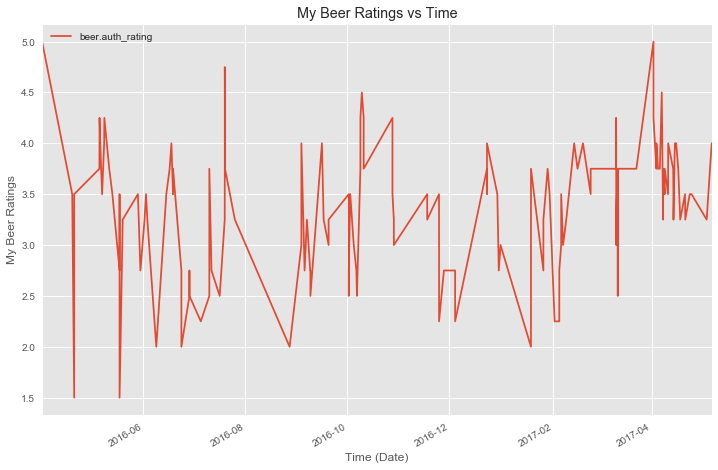

In [23]:
#Look at my ratings over time, any trends?
ax = filtered_my_beer_df.plot(x="create_date", y="beer.auth_rating")
ax.set_title('My Beer Ratings vs Time')
ax.set_xlabel('Time (Date)')
ax.set_ylabel('My Beer Ratings')
plt.show()

The above chart isn't very helpful, let's color-code by country to see if there are any trends that will reinforce our insights earlier.

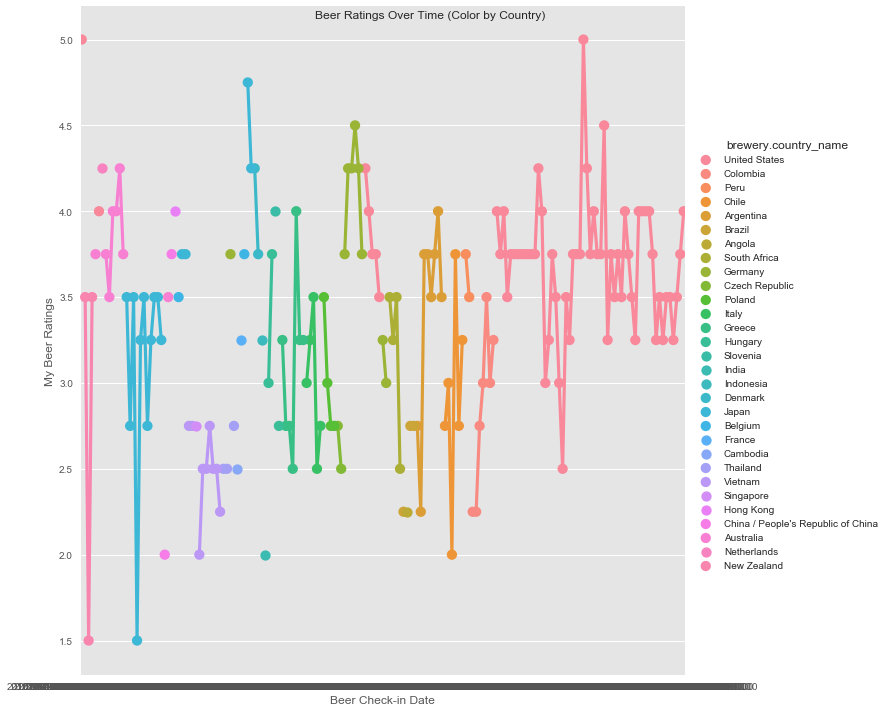

In [24]:
#Let's add a hue=brewery.country_name to see the ratings by country
gc = sns.factorplot(x='create_date', y='beer.auth_rating', hue='brewery.country_name', data=filtered_my_beer_df, 
               size=10, legend_out=True)
(gc.set_axis_labels("Beer Check-in Date", "My Beer Ratings")
   .fig.suptitle("Beer Ratings Over Time (Color by Country)"))  

I kind of like the plot above, let's create the same one by style to see if there are any trends that may correlate style and country.

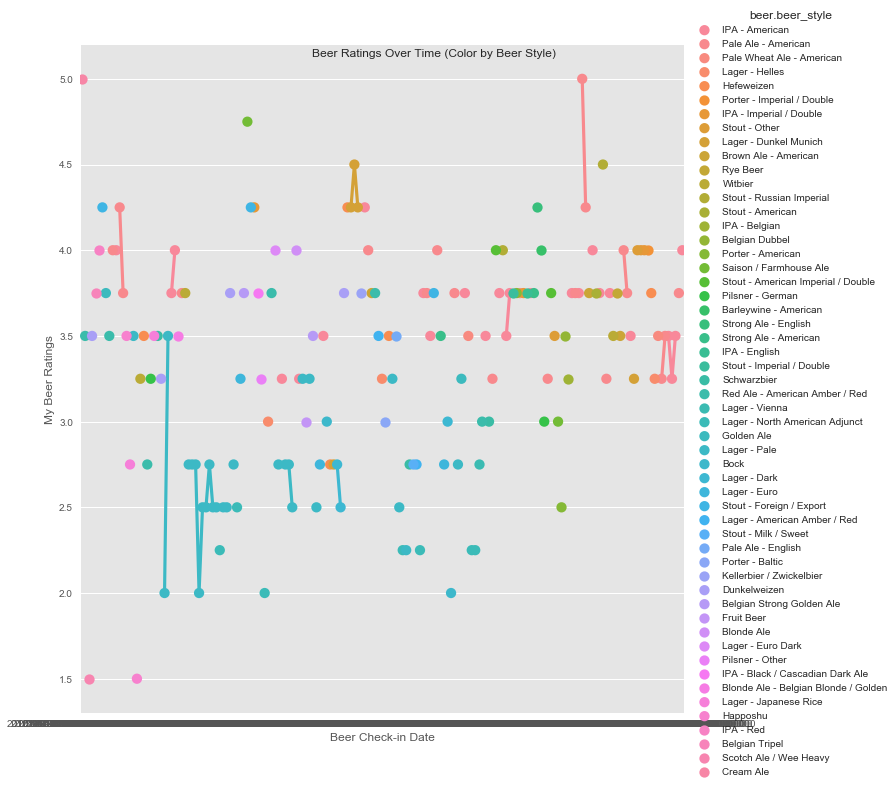

In [26]:
#Let's add a hue=beer.beer_style to see the ratings by style
gc = sns.factorplot(x='create_date', y='beer.auth_rating', hue='beer.beer_style', data=filtered_my_beer_df, 
               size=10)
(gc.set_axis_labels("Beer Check-in Date", "My Beer Ratings")
   .fig.suptitle("Beer Ratings Over Time (Color by Beer Style)"))

The major insight derived from the prior two plots / visuals, is that it appears that some countries are 'handicapped' since they only produce certain styles of beer. Either production is limited, or my individual sampling experience was limited. What this means is that since I do not prefer 'lager' style beers (and tend to rate those beers lower than the average user) if a country heavily produces 'lager' style beers - I do not prefer beer from that country! We will explore this further in the statistical inference portion of the project. 

# Summary

## The questions you asked


1.	How do my individual beer ratings compare to the average user’s ratings?
2.	Does there appear to be a difference in ratings based on style of beer?
3.	Does there appear to be a difference in ratings based on country of production?
4.	Do my individual ratings appear to change over time? 

## The trends you investigated & resulting conclusions

There are many interesting trends that I analyzed in this workbook. 

1. Looking at my individual beer ratings vs the average user, we see slight differences overall. When we look at the beer style level, however, we see much greater differences and are able to see which styles of beer I prefer (or do not prefer) when compared to the average user.

2. In analyzing beer style we were able to see that I prefer 'Ale' and 'Stout' beers much more than other styles. This is reinforced by the fact that I rate these styles higher than the average user. Similarly, I do not prefer 'lager' styles of beer.

3. When layering country of production, we saw some interesting trends that reinforced #1 & #2 above. Given that my wife and I have recently traveled to 28 countries I was able to sample beer made around the world. My preference by style was inherently seen in the country analysis as well. This is largely due to the fact that most countries only produce certain styles of beer (e.g. Vietnam, Thailand) and so if I did not prefer that style, my lower ratings are visible in both the style and country of production visuals.